# Dynamic range

In [1]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)

from network import run_network_recall, train_network, run_network_recall_limit
from connectivity import designed_matrix_sequences
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence

In [37]:
N = 10
self_excitation = 3.0
inhbition = 5.0
transition = 0.5
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

G = 100.0
tau_m = 0.010
tau_z = 0.020
T = 2.0
I_cue = 0
T_cue = 0.100
dt = 0.0001
threshold = 0.5

dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)

../network.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-G * x))


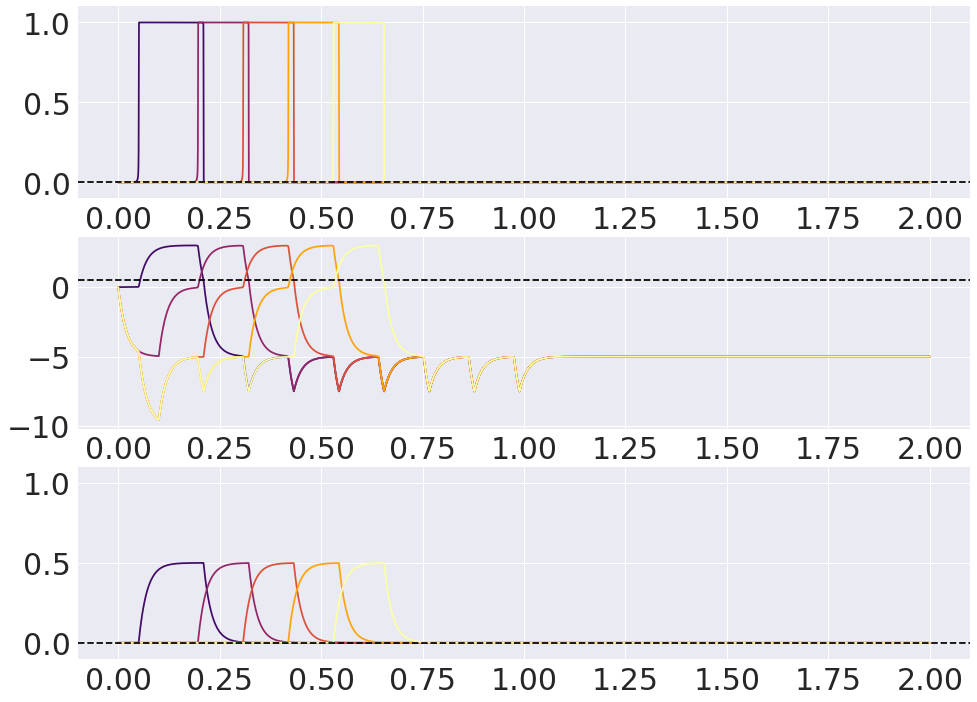

In [45]:
time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = [1, 2, 3, 4, 5]
cmap = matplotlib.cm.inferno
norm = matplotlib.colors.Normalize(0, len(patterns))

# patterns = sequence
for pattern in patterns:
    aux = current_history[:, pattern] - transition * z_history[:, pattern - 1]
    # aux = current_history[:, pattern]
    ax1.plot(time, x_history[:, pattern], color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, aux, color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, transition * z_history[:, pattern], color=cmap(norm(pattern)), label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')

ax1.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(threshold, ls='--', color='black')


ax3.axhline(0, ls='--', color='black')

# ax1.legend();
# ax2.legend();
# ax3.legend();

### Comparison with non-limited recall

In [33]:
N = 10
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
self_excitation = 3.0
transition = 0.5
inhibition = 30.0

G = 120.0
tau_m = 0.010
tau_z = 0.020
T = 5.0
I_cue = 0
T_cue = 0.100
dt = 0.001

threshold = 0.5
tau_z = 0.050

pattern = 5
transition_vector = np.arange(0.40, 2.0, 0.05)
recall_times = []
recall_times_limit = []
for transition in transition_vector:
    w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, transition=transition, 
                              inhbition=inhibition)

    dic = run_network_recall(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
    x_history = dic['x']
    duration = get_recall_duration_for_pattern(x_history, pattern, dt)
    recall_times.append(duration)
    dic = run_network_recall_limit(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)
    x_history = dic['x']
    duration = get_recall_duration_for_pattern(x_history, pattern, dt)
    recall_times_limit.append(duration)

../network.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-G * x))


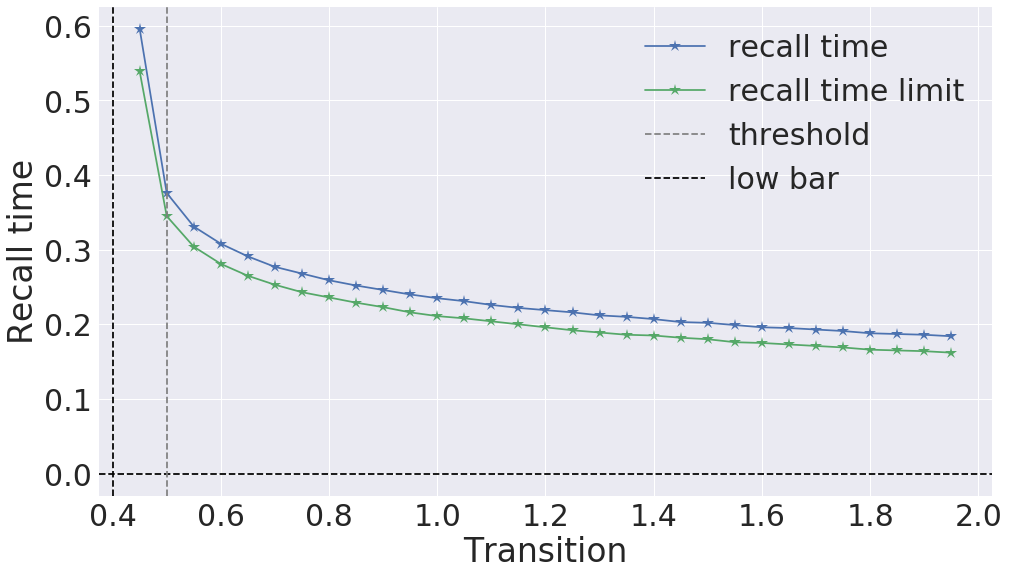

In [34]:
plt.plot(transition_vector, recall_times, '*-', markersize=13, label='recall time')
plt.plot(transition_vector, recall_times_limit, '*-', markersize=13, label='recall time limit')

plt.axhline(0, ls='--', color='black')
plt.axvline(threshold, ls='--', color='gray', label='threshold')
plt.axvline(transition_vector[0], ls='--', color='black', label='low bar')
plt.xlabel('Transition')
plt.ylabel('Recall time')
plt.legend();

## Looking inside the currents
Something is gronw, it seems tha for some reasons the threshold is actually **lower** than it should be. Threfore,, the transition term can become smaller than the actual trheshold but the transition still happens.

In [61]:
from network import phi

def run_network_recall_limit_inside(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue, sigma=0):

    x = np.zeros(N)
    current = np.zeros(N)
    current_A = np.zeros(N)
    current_T = np.zeros(N)
    current_I = np.zeros(N)
    current_rest = np.zeros(N)

    z = np.zeros(N)
    x[I_cue] = 1.0  # Initial condition
    z[I_cue] = 0.0

    x_history = []
    z_history = []
    current_history = []
    current_A_history = []
    current_T_history = []
    current_I_history = []
    current_rest_history = []

    steps = int(T / dt)
    steps_cue = int(T_cue / dt)
    for i in range(steps):
        x_history.append(np.copy(x))
        z_history.append(np.copy(z))
        current_history.append(np.copy(current))
        current_A_history.append(np.copy(current_A))
        current_T_history.append(np.copy(current_T))
        current_I_history.append(np.copy(current_I))
        current_rest_history.append(np.copy(current_rest))
    
        for k in range(N):
            current_A[k] = z[k] * w[k, k]
            index_transition = (k - 1) % N
            current_T[k] = z[index_transition] * w[k, index_transition]
            index_inhibition = (k + 1)  % N
            current_I[k] = z[index_inhibition] * w[k, index_inhibition]

        current_rest = current - current_A - current_I - current_T

        current = np.dot(w, z) + sigma * np.random.randn(N)
        x = phi(G, current - threshold)
        if i < steps_cue:
            x[I_cue] = 1
        z += (dt / tau_z) * (x - z)

    x_history = np.array(x_history)
    z_history = np.array(z_history)
    current_history = np.array(current_history)
    current_A_history = np.array(current_A_history)
    current_T_history = np.array(current_T_history)
    current_I_history = np.array(current_I_history)
    current_rest_history = np.array(current_rest_history)

    dic = {}
    dic['x'] = x_history
    dic['z'] = z_history
    dic['current'] = current_history
    dic['current_A'] = current_A_history
    dic['current_I'] = current_I_history
    dic['current_T'] = current_T_history
    dic['current_rest'] = current_rest_history

    return dic

In [73]:
N = 10
self_excitation = 3.0
inhbition = 5.0
transition = 0.8
sequences = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhbition=inhbition)

G = 100.0
tau_m = 0.010
tau_z = 0.020
T = 1.0
I_cue = 0
T_cue = 0.100
dt = 0.0001
threshold = 0.5

dic = run_network_recall_limit_inside(N, w, G, threshold, tau_m, tau_z,  T, dt, I_cue, T_cue)

../network.py:5: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-G * x))


I want to see how much the self-excitation current plus the transition current account for the activation of a unit

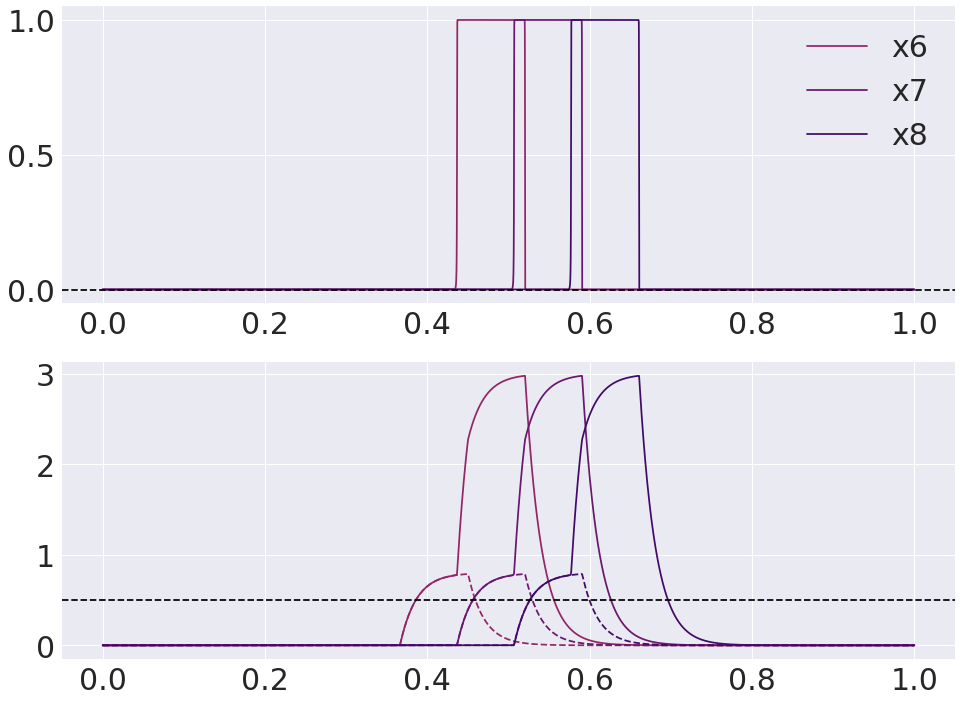

In [82]:
time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']
current_A = dic['current_A']
current_T = dic['current_T']
current_I = dic['current_I']
current_rest = dic['current_rest']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(413)
# ax4 = fig.add_subplot(414)

patterns = [6, 7, 8]
cmap = matplotlib.cm.inferno_r
norm = matplotlib.colors.Normalize(0, N)

# patterns = sequence
for pattern in patterns:
    aux = current_A[:, pattern] + current_T[:, pattern]
    ax1.plot(time, x_history[:, pattern] , color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, aux, color=cmap(norm(pattern)), label='current' + str(pattern))
    ax2.plot(time, current_T[:, pattern], ls='--', color=cmap(norm(pattern)), label='x' + str(pattern))

ax1.axhline(0, ls='--', color='black')

# ax1.set_ylim([-0.1, 1.1])
# ax3.set_ylim([-0.1, 1.1])

ax2.axhline(threshold, ls='--', color='black')

ax1.legend()

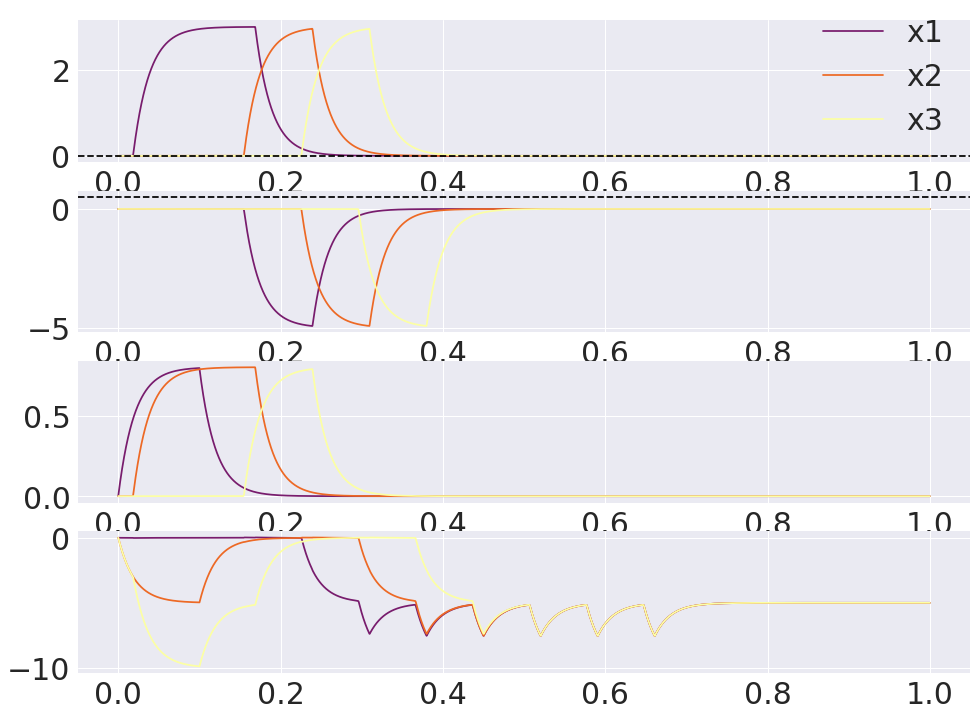

In [81]:
time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']
current_A = dic['current_A']
current_T = dic['current_T']
current_I = dic['current_I']
current_rest = dic['current_rest']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

patterns = [1, 2, 3]
cmap = matplotlib.cm.inferno
norm = matplotlib.colors.Normalize(0, len(patterns))

# patterns = sequence
for pattern in patterns:
    # aux = current_history[:, pattern] - transition * z_history[:, pattern - 1]
    # aux = current_history[:, pattern]
    ax1.plot(time, current_A[:, pattern], color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, current_I[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, current_T[:, pattern], color=cmap(norm(pattern)), label='z ' + str(pattern))
    ax4.plot(time, current_rest[:, pattern], color=cmap(norm(pattern)), label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')

# ax1.set_ylim([-0.1, 1.1])
# ax3.set_ylim([-0.1, 1.1])

ax2.axhline(threshold, ls='--', color='black')

ax1.legend()

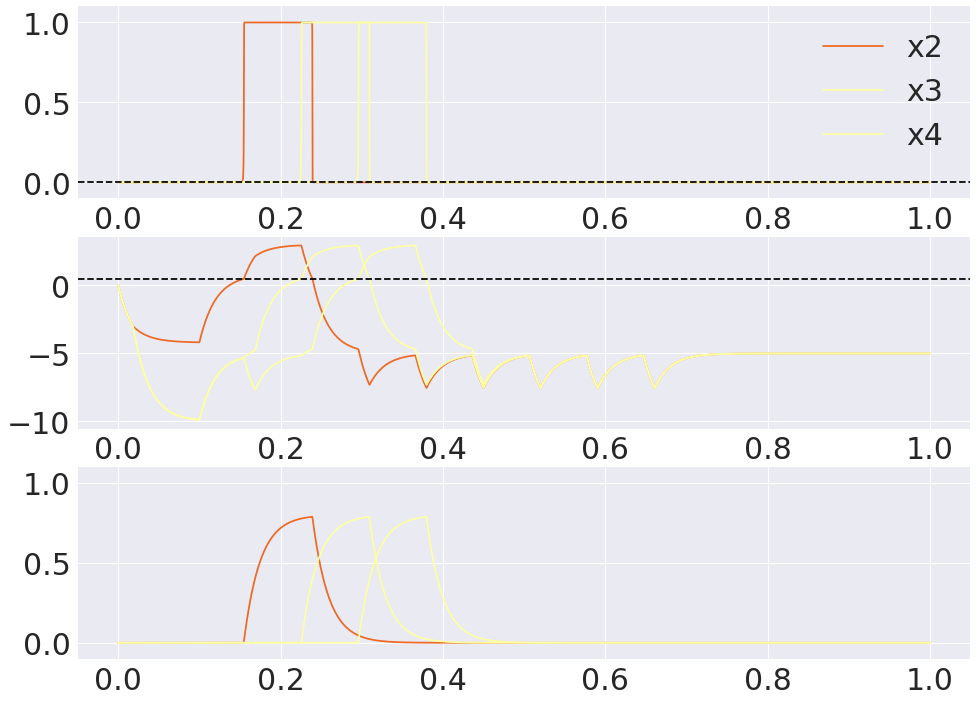

In [76]:
time = np.arange(0, T, dt)
x_history = dic['x']
z_history = dic['z']
current_history = dic['current']
current_A = dic['current_A']
current_T = dic['current_T']
current_I = dic['current_I']
current_rest = dic['current_rest']

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

patterns = [2, 3, 4]
cmap = matplotlib.cm.inferno
norm = matplotlib.colors.Normalize(0, len(patterns))

# patterns = sequence
for pattern in patterns:
    ax1.plot(time, x_history[:, pattern], color=cmap(norm(pattern)), label='x' + str(pattern))
    ax2.plot(time, current_history[:, pattern], color=cmap(norm(pattern)), label='current' + str(pattern))
    ax3.plot(time, transition * z_history[:, pattern], color=cmap(norm(pattern)), label='z ' + str(pattern))
    
ax1.axhline(0, ls='--', color='black')

ax1.set_ylim([-0.1, 1.1])
ax3.set_ylim([-0.1, 1.1])

ax2.axhline(threshold, ls='--', color='black')

ax1.legend()